In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco

onehot_data = np.load('extracted_onehot.npy')[:,:]
hypothetical_data = np.load('extracted_hypothetical_scores.npy')[:,:]
meannorm_hypothetical_data = (hypothetical_data
                              -np.mean(hypothetical_data, axis=-1)[:,:,None])
contrib_data = np.load('extracted_contrib_scores.npy')[:,:]
#perposimp_hypmeannorm = np.sum(meannorm_hypothetical_data*onehot_data,axis=-1)
perposimp = np.sum(contrib_data*onehot_data,axis=-1)

flanksize=20
contrib_scores_track = modisco.core.DataTrack(name="contrib_scores",
                                 fwd_tracks=contrib_data,
                                 rev_tracks=contrib_data[:,::-1, ::-1])
hypcontrib_scores_track = modisco.core.DataTrack(name="hypcontrib_scores",
                                    fwd_tracks=hypothetical_data,
                                    rev_tracks=hypothetical_data[:,::-1, ::-1])
meannorm_hypcontrib_scores_track = modisco.core.DataTrack(name="meannorm_hypcontrib_scores",
                                    fwd_tracks=meannorm_hypothetical_data,
                                    rev_tracks=meannorm_hypothetical_data[:,::-1, ::-1])
onehot_track = modisco.core.DataTrack(
                 name="onehot", fwd_tracks=onehot_data,
                 rev_tracks=onehot_data[:,::-1, ::-1])
track_set = modisco.core.DataTrackSet(data_tracks=[
                contrib_scores_track, hypcontrib_scores_track,
                meannorm_hypcontrib_scores_track, onehot_track
               ])

coords = []
for example_idx in range(len(onehot_data)):
    #figure out the 6bp window with highest imp
    padded_cumsum = np.array([0]+list(np.cumsum(perposimp[example_idx][50:50+41])))
    sliding_window_imp = padded_cumsum[7:] - padded_cumsum[:-7]
    start = np.argmax(sliding_window_imp)+50
    coords.append(modisco.core.Coordinate(
                    example_idx=example_idx, start=start-17,
                    end=start+24, is_revcomp=False))

all_seqlets = [x for x in track_set.create_seqlets(coords=coords, flanks=30)
               if np.sum(x["contrib_scores"].corefwd) > 0]


/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
n_seqlets_in_subsample = 5000 #len(all_seqlets)#40000
seqlets_subsample = [all_seqlets[i] for i in np.random.RandomState(1).choice(
                     np.arange(len(all_seqlets)), size=n_seqlets_in_subsample,replace=False)]

In [120]:
import numba
from deeplift.visualization import viz_sequence

corelen=41
min_overlap_frac=0.75

#define a numba metric to compute similarity
@numba.njit(fastmath=True, cache=True)
def sliding_window_projected_contin_jacc(x, y):
    x_orig_onehot = x[:int(len(x)/2)].reshape((-1, 4))
    x_orig_hyp = x[int(len(x)/2):].reshape((-1,4))
    y_orig_onehot = y[:int(len(y)/2)].reshape((-1,4))
    y_orig_hyp = y[int(len(y)/2):].reshape((-1,4))
    
    assert x_orig_onehot.shape==y_orig_onehot.shape
    assert x_orig_hyp.shape==y_orig_hyp.shape
    assert x_orig_onehot.shape==x_orig_hyp.shape
    
    flanklen = int((len(x_orig_onehot)-corelen)/2)
    
    min_overlap = int(np.ceil(corelen*min_overlap_frac))
    
    x_orig_actual = x_orig_hyp*x_orig_onehot
    y_orig_actual = y_orig_hyp*y_orig_onehot
    
    startoffset = -(corelen-min_overlap)
    endoffset = (corelen - min_overlap)
    assert (corelen-min_overlap) < flanklen
    
    max_sim = -np.inf
    max_imputedx = -np.inf
    max_imputedy = -np.inf
    for revcomp in [False, True]:
        if (revcomp==False):
            x_onehot = x_orig_onehot
            x_hyp = x_orig_hyp 
            y_onehot = y_orig_onehot
            y_hyp = y_orig_hyp
            x_actual = x_orig_actual
            y_actual = y_orig_actual
        else:
            x_onehot = x_orig_onehot
            x_hyp = x_orig_hyp
            y_onehot = y_orig_onehot[::-1, ::-1]
            y_hyp = y_orig_hyp[::-1, ::-1]
            x_actual = x_orig_actual
            y_actual = y_orig_actual[::-1, ::-1]
        
        for offset in range(startoffset, endoffset+1):
            y_leftpad = max(offset, 0)
            y_slicestart = flanklen-y_leftpad
            y_rightpad = max(corelen-(corelen+offset),0)
            overlap_size = y_leftpad + corelen + y_rightpad

            x_leftpad = max(-offset, 0)
            x_slicestart = flanklen-x_leftpad
            
            imputedx_l1norm = 0
            imputedy_l1norm = 0
            actualx_l1norm = 0
            actualy_l1norm = 0
            x_actual_list = []
            y_actual_list = []
            x_imputed_list = []
            y_imputed_list = []
            for pos_idx in range(overlap_size):
                x_pos_idx = x_slicestart + pos_idx
                y_pos_idx = y_slicestart + pos_idx
                for base_idx in range(4):
                    x_actual_here = x_actual[x_pos_idx, base_idx]
                    y_actual_here = y_actual[y_pos_idx, base_idx]
                    x_imputed_here = x_hyp[x_pos_idx, base_idx]*y_onehot[y_pos_idx, base_idx]
                    y_imputed_here = y_hyp[y_pos_idx, base_idx]*x_onehot[x_pos_idx, base_idx]
                    
                    imputedx_l1norm += abs(x_imputed_here)
                    imputedy_l1norm += abs(y_imputed_here)
                    actualx_l1norm += abs(x_actual_here)
                    actualy_l1norm += abs(y_actual_here)
                    
                    x_actual_list.append(x_actual_here)
                    y_actual_list.append(y_actual_here)
                    x_imputed_list.append(x_imputed_here)
                    y_imputed_list.append(y_imputed_here)
                    
            imputedx_union = 0
            imputedx_intersection = 0
            imputedy_union = 0
            imputedy_intersection = 0
            for i in range(len(x_actual_list)):
                x_actual_here = x_actual_list[i]/actualx_l1norm
                y_actual_here = y_actual_list[i]/actualy_l1norm
                x_imputed_here = x_imputed_list[i]/imputedx_l1norm
                y_imputed_here = y_imputed_list[i]/imputedy_l1norm

                abs_x_actual_here = abs(x_actual_here)
                abs_y_actual_here = abs(y_actual_here)
                abs_x_imputed_here = abs(x_imputed_here)
                abs_y_imputed_here = abs(y_imputed_here)

                imputedx_union += max(abs_x_imputed_here,abs_y_actual_here)
                imputedy_union += max(abs_y_imputed_here,abs_x_actual_here)
                imputedx_intersection += (np.sign(x_imputed_here)*np.sign(y_actual_here)
                                          *min(abs_x_imputed_here,abs_y_actual_here))
                imputedy_intersection += (np.sign(y_imputed_here)*np.sign(x_actual_here)
                                          *min(abs_y_imputed_here,abs_x_actual_here))

            imputedx_sim = (imputedx_intersection/imputedx_union)
            imputedy_sim = (imputedy_intersection/imputedy_union)
            sim = 0.5*(imputedx_sim+imputedy_sim)
            max_sim = max(max_sim, sim)
            max_imputedx = max(max_imputedx, imputedx_sim)
            max_imputedy = max(max_imputedy, imputedy_sim)
    
    #print(0.5*(max_imputedx+max_imputedy)) for debugging
    return 1 - 0.5*(max_imputedx+max_imputedy) #for comparison with old calc, for now
    #return 1-max_sim


In [121]:

def get_feature_vectors(seqlets, scoretracknames, flanksize):
    feature_vectors = []
    for seqlet in seqlets:
        tracks = [seqlet[scoretrackname].get_core_with_flank(left=flanksize, right=flanksize,
                                                             is_revcomp=False)
                  for scoretrackname in scoretracknames]
        concatenated_tracks = np.concatenate(tracks, axis=0)
        feature_vectors.append(concatenated_tracks.ravel())
    return np.array(feature_vectors)

featvec = get_feature_vectors(seqlets=seqlets_subsample,
                              scoretracknames=["onehot", "hypcontrib_scores"],
                              flanksize=flanksize)

In [122]:
#test that the similarity is computed correctly
from modisco.affinitymat import asymmetric_compute_sim_on_pair
import modisco.util

seql1 = seqlets_subsample[0]
seql2 = seqlets_subsample[1]

sim_dir1 = max([max(asymmetric_compute_sim_on_pair(
    seql1_corelen=corelen,
    seql1_hyp=seql1["hypcontrib_scores"].get_core_with_flank(left=flanksize, right=flanksize, is_revcomp=False),
    seql1_onehot=seql1["onehot"].get_core_with_flank(left=flanksize, right=flanksize, is_revcomp=False),                       
    seql2_corelen=corelen,
    seql2_hyp=seql2["hypcontrib_scores"].get_core_with_flank(left=flanksize, right=flanksize, is_revcomp=is_revcomp),                                       
    min_overlap_frac=min_overlap_frac,
    pair_sim_metric=modisco.util.l1norm_contin_jaccard_sim)[0])
           for is_revcomp in [False, True]])
sim_dir2 = max([max(asymmetric_compute_sim_on_pair(
    seql1_corelen=corelen,
    seql1_hyp=seql2["hypcontrib_scores"].get_core_with_flank(left=flanksize, right=flanksize, is_revcomp=False),
    seql1_onehot=seql2["onehot"].get_core_with_flank(left=flanksize, right=flanksize, is_revcomp=False),                       
    seql2_corelen=corelen,
    seql2_hyp=seql1["hypcontrib_scores"].get_core_with_flank(left=flanksize, right=flanksize, is_revcomp=is_revcomp),                                       
    min_overlap_frac=min_overlap_frac,
    pair_sim_metric=modisco.util.l1norm_contin_jaccard_sim)[0])
           for is_revcomp in [False, True]])

print(0.5*(sim_dir1 + sim_dir2))
print(1-sliding_window_projected_contin_jacc(x=featvec[0], y=featvec[1]))

0.09983108751475811
0.09983108452837175


In [123]:
#get a similarity using pynndescent
from pynndescent import NNDescent
import time
n_neighbors = 20
start = time.time()
nnd = NNDescent(data=featvec,
                n_neighbors=n_neighbors,
                metric=sliding_window_projected_contin_jacc,
                #metric_kwds={'corelen':41, 'min_overlap_frac':0.75},
                random_state=1234,
                max_candidates=60, #value used in UMAP: https://github.com/lmcinnes/umap/blob/9f66cafdef9c666082b2da188c2ae9bff60bc763/umap/umap_.py#L297
                verbose=True,
                tree_init=True,
                n_jobs=4)
knn_indices, knn_dists = nnd.neighbor_graph
print("Took:",time.time()-start,"s")

Thu Apr  2 09:43:33 2020 Building RP forest with 9 trees
Thu Apr  2 09:43:33 2020 parallel NN descent for 12 iterations
	 0  /  12
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
Took: 2101.1346650123596 s


In [124]:
#let's investigate concordance between remapped_indices and the contin-jacc approach

In [125]:
continjacc_affmat = np.load("affmat_recenter_41bpseqlets_0.75.npy")

In [143]:
np.save("pynndescapprox_affmat_recenter_41bpseqlets_0.75.npy", (knn_indices, knn_dists))

In [126]:
def get_nn_ranking_for_affmat(affmat):
    nn_ranking = np.zeros_like(affmat).astype("int")
    for row_idx,row in enumerate(affmat):
        row_argsort = np.argsort(-row)
        nn_ranking[row_idx,row_argsort] = np.arange(len(row_argsort))
    return nn_ranking

continjacc_nn_ranking = get_nn_ranking_for_affmat(continjacc_affmat)

In [127]:
continjacc_nn_ranking_of_pnndesc_neighbs = np.array([
    continjacc_nn_ranking[row_idx, row_knn_indices]
    for (row_idx, row_knn_indices) in enumerate(knn_indices)
])

In [128]:
continjacc_nn_ranking_of_pnndesc_neighbs

array([[ 0,  1,  2, ..., 24, 25, 26],
       [ 0,  1,  2, ..., 17, 18, 19],
       [ 0,  1,  2, ..., 17, 18, 19],
       ...,
       [ 1,  0,  2, ..., 17, 18, 19],
       [ 0,  1,  2, ..., 17, 18, 19],
       [ 0,  1,  2, ..., 17, 18, 19]])

In [129]:
continjacc_nn_ranking

array([[   0, 2389, 3745, ..., 1680,   43, 2801],
       [2862,    0, 2150, ..., 3014,  806, 1856],
       [3849, 1564,    0, ..., 3956, 1733, 2922],
       ...,
       [ 668, 1343, 2492, ...,    0,  477,  853],
       [ 642,  329, 1698, ..., 1857,    0, 2757],
       [3842, 1169, 3523, ..., 3145, 3823,    0]])

In [130]:
knn_indices

array([[   0,  344,  148, ..., 1594, 1382, 1605],
       [   1, 2546, 1186, ..., 3056, 3033, 2479],
       [   2, 1444, 2195, ..., 1254, 2936, 1921],
       ...,
       [1239, 4997, 2776, ..., 2445, 2179,  251],
       [4998, 2756, 2028, ..., 4887, 2451, 1916],
       [4999,  944, 1486, ..., 2672, 3180, 1303]])

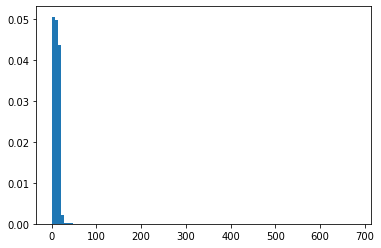

In [138]:
from matplotlib import pyplot as plt

plt.hist(continjacc_nn_ranking_of_pnndesc_neighbs.ravel(), bins=100, density=True)
plt.show()